# 1.Data
1.1Energy consumption data

1.1.1Importing energy data

The hourly energy consumption data for the 4 utilities- PGE (Pacific Gas and Electric), SCE (Southern California Edison), SDGE (San Diego Gas and Electric) and VEA (Valley Electric Association, which actually covers some parts of Nevada)- under the CAISO (California Independent System Operator) is available on CAISO’s website in the form of .csv files. The most recent data for past 3 months and 2020 is available on http://www.caiso.com/planning/Pages/ReliabilityRequirements/Default.aspx and previous data upto 2018 is available.

Python’s requests and html packages were used to extract the .csv files directly from the websites and stored in dictionaries before concatenating them into a single dataframe.

In [1]:
# importing all the required libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
from lxml import html
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import matplotlib.dates as mdates
plt.style.use('bmh')

In [2]:
#Storing the data URLs; the first URL has the most recent data (2018-2019) and the archive URL has old data (2014-2017)
url = "http://www.caiso.com/planning/Pages/ReliabilityRequirements/Default.aspx"
#url_archive="http://www.caiso.com/planning/Pages/ReliabilityRequirements/ReliabilityRequirementsArchive.aspx"
url_archive = "http://www.caiso.com/planning/Pages/ReliabilityRequirements/Default.aspx"

In [3]:
#Requesting the data and getting a response from both the URls
r = requests.get(url)
r_archive = requests.get(url_archive)


In [4]:
#getting the html content 
tree = html.fromstring(r.content)
tree_archive = html.fromstring(r_archive.content)


In [5]:
#Using xpath and web scrapping to get the exact location of the data files on the website by using inspect method on the websites
file = tree.xpath('//*[@id="NodeTempate"]/a[@class="ISOTreeNodeTxt"]//@href') 
file_archive = tree_archive.xpath('//*[@id="NodeTempate"]/a[@class="ISOTreeNodeTxt"]//@href') 

In [6]:
#Checking if files were imported correctly; the hourly data is stored in all files starting with "Historical..."
hourly_data=[]
for doc in file:
    if "Historical" in doc:
        print(doc)
        hourly_data.append(doc)


/Documents/HistoricalResourceAdequacyImportAggregateData.xlsx
/Documents/HistoricalEMSHourlyLoadforNovember2021.xlsx
/Documents/HistoricalEMSHourlyLoadforOctober2021.xlsx
/Documents/HistoricalEMSHourlyLoadforSeptember2021.xlsx
/Documents/HistoricalEMSHourlyLoadforAugust2021.xlsx
/Documents/HistoricalEMSHourlyLoadforJuly2021.xlsx
/Documents/HistoricalEMSHourlyLoadforJune2021.xlsx
/Documents/HistoricalEMSHourlyLoadforMay2021.xlsx
/Documents/HistoricalEMSHourlyLoadforApril2021.xlsx
/Documents/HistoricalEMSHourlyLoadforMarch2021.xlsx
/Documents/HistoricalEMSHourlyLoadforFebruary2021.xlsx
/Documents/HistoricalEMSHourlyLoadforJanuary2021.xlsx
/Documents/HistoricalEMSHourlyLoad-2020.xlsx
/Documents/HistoricalEMSHourlyLoad-2019.xlsx
/Documents/HistoricalEMSHourlyLoad-2018.xlsx


In [7]:
hourly_data=hourly_data[1:]

In [8]:
#split 2019-2018
hourly_data_arch=hourly_data[12:]


In [9]:
#reading in all the archive excel files into a dict: hourly_arch_dict with key names with respective years in it
hourly_arch_dict={}
for doc1 in file_archive:
    if "Historical" in doc1:
        hourly_arch_dict['hourly_load'+'_'+doc1.strip('.xlsx')[-4:]]=pd.read_excel('http://www.caiso.com'+doc1)

In [10]:
#Checking the dict if the keys were named correctly
del hourly_arch_dict['hourly_load_Data']
del hourly_arch_dict['hourly_load_2021']
hourly_arch_dict.keys()

dict_keys(['hourly_load_2020', 'hourly_load_2019', 'hourly_load_2018'])

1.1.2 Cleaning energy data

In [11]:
#Checking the tail of the data for each year
for keys, items in hourly_arch_dict.items():
    print("\ntail of "+keys+"\n")
    print(items.tail()[3:])


tail of hourly_load_2020

           Date  HE           PGE          SCE         SDGE        VEA  \
8782 2020-12-31  23  10419.583410  10555.31471  2248.671787  78.217945   
8783 2020-12-31  24   9999.346461  10151.50315  2147.732735  76.085979   

      CAISO Total Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  \
8782  23301.78666        NaN         NaN         NaN          NaN   
8783  22374.67709        NaN         NaN         NaN          NaN   

      Unnamed: 11  Unnamed: 12  
8782          NaN          NaN  
8783          NaN          NaN  

tail of hourly_load_2019

           Date  HE           PGE           SCE         SDGE        VEA  \
8758 2019-12-31  23  10707.203302  10259.203753  2212.400524  82.408524   
8759 2019-12-31  24  10418.888072   9825.389996  2094.276516  83.185773   

       CAISO Total Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  \
8758  23292.393765        NaN         NaN         NaN          NaN   
8759  22452.914219        NaN         NaN         

The Dates column is the datetime column and the columns PGE, SCE, SDGE, VEA represent the energy consumption in the respective utility regions in MWH ( Wh). And the 'CAISO Total' column gives the sum of the energy consumption of these 4 utiltiy regions.

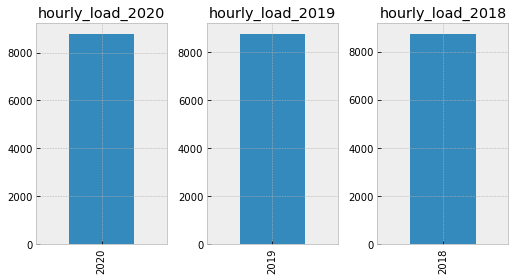

In [12]:
#for keys, items in hourly_arch_dict.items():
#    print("\n"+keys+"\n")
#    print(items.groupby(items['Dates'].dt.year).count())
plt.figure(figsize = (12,4))
for i, (keys, items) in enumerate(hourly_arch_dict.items()):
    ax = plt.subplot(151+i)
    items['Date'].dt.year.value_counts().plot(kind='bar', subplots = True, ax = ax)
    ax.set_title("{}".format(keys))
plt.tight_layout()


Let's concatenate the data into a single dataframe before starting the cleaning process

In [13]:
hourly1820 = pd.concat(hourly_arch_dict, axis='rows', ignore_index=True)
hourly1820=hourly1820.sort_values(by=['Date','HE'])

hourly1820=hourly1820.reset_index(drop=True)
hourly1820 = hourly1820[['Date','HE','PGE','SCE','SDGE','VEA','CAISO Total']]

In [14]:
hourly1820.head()

,Date,HE,PGE,SCE,SDGE,VEA,CAISO Total
0,2018-01-01,0,10023.052203,9957.145479,2123.183153,71.222568,22174.603618
1,2018-01-01,1,9577.460722,9457.930894,2020.884747,72.305666,21128.582029
2,2018-01-01,2,9448.628231,9086.318907,1920.035651,74.157034,20529.139823
3,2018-01-01,3,9260.239499,8795.615734,1848.166301,76.855463,19980.876996
4,2018-01-01,4,9108.429730,8619.310631,1811.712796,79.176253,19618.629410


In [15]:
hourly1820.groupby(hourly1820['Date'].dt.year).count()


,Date,HE,PGE,SCE,SDGE,VEA,CAISO Total
Date,,,,,,,
2018,8737,8737,8737,8737,8737,8737,8737
2019,8760,8760,8760,8760,8760,8760,8760
2020,8784,8784,8784,8784,8784,8784,8784



Converting the energy consumption values to numeric; while converting to numeric, it was observed that some of the values in the columns were strings, so passing the errors='coerce' argument to the pd.to_numeric method. Also, after the conversion checking for any null values.

In [16]:
for col in hourly1820.columns[2:]:
    hourly1820[col]=pd.to_numeric(hourly1820[col], errors='coerce')


In [17]:
# Checking for missing values in each column
hourly1820.isnull().sum()

Date           0
HE             0
PGE            0
SCE            0
SDGE           0
VEA            0
CAISO Total    0
dtype: int64

We have no missing values. But if we have we can choose how to fill them. Since this is an energy consumption data, we need to keep in mind that the energy consumption of a region (including cities and rural) changes depending on the hour of the day, day of the week, month of the year, season and the year itself. So, we can fill the missing values with the average values of the matching month and weekday for the same hours from the rest of the data for that year.

Plotting the data to check if all the data cleaning opeations were successful and there are no outliers

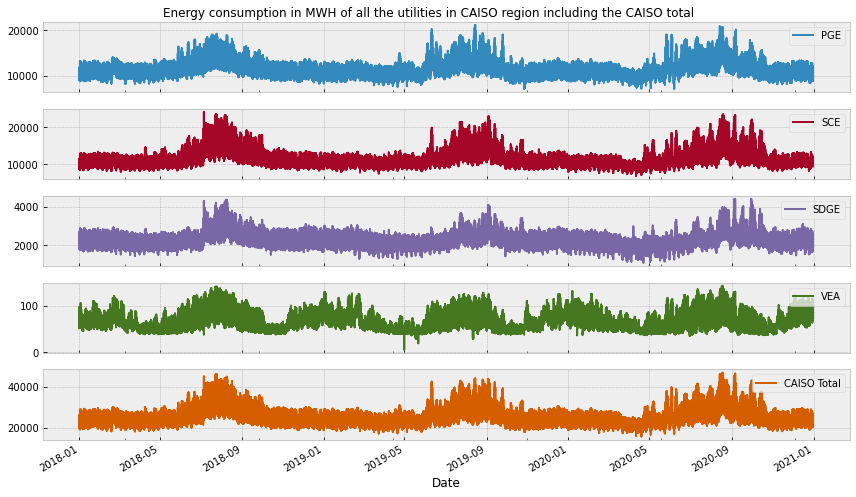

In [18]:
hourly1820.set_index('Date')[['PGE', 'SCE', 'SDGE', 'VEA', 'CAISO Total']].plot(subplots = True, figsize = (12,7))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.suptitle('Energy consumption in MWH of all the utilities in CAISO region including the CAISO total')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)


Checking the descriptive stats of the data

In [19]:
hourly1820.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26281 entries, 0 to 26280
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         26281 non-null  datetime64[ns]
 1   HE           26281 non-null  int64         
 2   PGE          26281 non-null  float64       
 3   SCE          26281 non-null  float64       
 4   SDGE         26281 non-null  float64       
 5   VEA          26281 non-null  float64       
 6   CAISO Total  26281 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 MB


In [20]:
hourly1820.describe().T

,count,mean,std,min,25%,50%,75%,max
HE,26281.0,12.167041,6.938715,0.000000,6.000000,12.000000,18.000000,24.000000
PGE,26281.0,11426.260806,1958.172703,7205.070366,10019.701887,11112.351184,12300.114765,21090.578935
SCE,26281.0,11557.111847,2610.569111,6818.951874,9744.702889,10987.251750,12414.999029,24095.516035
SDGE,26281.0,2217.743128,448.386923,1090.972357,1888.491498,2139.028919,2452.974024,4407.461052
VEA,26281.0,66.967681,19.934071,5.713822,51.907764,61.871888,78.517787,143.283509
CAISO Total,26281.0,25269.606571,4868.804265,15590.550952,21790.722981,24363.625211,27214.868369,46973.905016


In [21]:
hourly1820.to_csv('hourly1820CA.csv')

1.1.3. Adding features to energy data

Focusing only on one utility for now-SDGE (San Diego Gas & Electric); selecting smaller region will make it easier in the future to import the weather data and use it as a forecasting parameter.
Reading in the hourly energy consumption .csv file

In [22]:
hSDGE1820 = pd.read_csv('hourly1820CA.csv',usecols=['Date','HE','SDGE'], parse_dates=['Date'])

In [23]:
hSDGE1820.head()

,Date,HE,SDGE
0,2018-01-01,0,2123.183153
1,2018-01-01,1,2020.884747
2,2018-01-01,2,1920.035651
3,2018-01-01,3,1848.166301
4,2018-01-01,4,1811.712796


In [24]:
hSDGE1820.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26281 entries, 0 to 26280
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    26281 non-null  datetime64[ns]
 1   HE      26281 non-null  int64         
 2   SDGE    26281 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 616.1 KB


In [25]:
hSDGE1820.describe().T

,count,mean,std,min,25%,50%,75%,max
HE,26281.0,12.167041,6.938715,0.000000,6.000000,12.000000,18.000000,24.000000
SDGE,26281.0,2217.743128,448.386923,1090.972357,1888.491498,2139.028919,2452.974024,4407.461052



Adding weekdays, month, day of the month, hour of the day, year, season as extra columns.
Mapping the weekdays to a dict to use the actual weekdays in words like 'Monday', etc. Python usually indicates Monday as 0, Tuesday as 1 and so on.
Adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works; months from June to October are denoted as 'summer' and months from November to May as 'winter'.
Adding holidays column to indicate whether a day was a holiday as per the US calendar or not.


In [26]:
def season_calc(month):
    """adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works; 
       months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
    if month in [6,7,8,9,10]:
        return "summer"
    else:
        return "winter"


In [27]:


weekdays = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
hSDGE1820['year'] = hSDGE1820.Date.dt.year
hSDGE1820['month'] = hSDGE1820.Date.dt.month
hSDGE1820['day'] = hSDGE1820.Date.dt.day
hSDGE1820['hour'] = hSDGE1820['HE']
hSDGE1820['weekday'] = hSDGE1820.Date.dt.weekday.map(weekdays)
hSDGE1820['season'] = hSDGE1820.Date.dt.month.apply(season_calc)


In [28]:
#Adding holidays column to indicate whether a day was a holiday as per the US calendar or not

cal = calendar()
holidays = cal.holidays(start=hSDGE1820['Date'].min(),end=hSDGE1820['Date'].max())
hSDGE1820['holiday'] = hSDGE1820['Date'].isin(holidays)

In [29]:
#converting the holiday column to 1 and 0, 1 indicating a holiday and 0 not a holiday; using dictionary and map to achieve this

mapped = {True:1,False:0}
hSDGE1820.holiday = hSDGE1820.holiday.map(mapped)
hSDGE1820.drop('HE',inplace=True,axis=1)
hSDGE1820.head()

,Date,SDGE,year,month,day,hour,weekday,season,holiday
0,2018-01-01,2123.183153,2018,1,1,0,Monday,winter,1
1,2018-01-01,2020.884747,2018,1,1,1,Monday,winter,1
2,2018-01-01,1920.035651,2018,1,1,2,Monday,winter,1
3,2018-01-01,1848.166301,2018,1,1,3,Monday,winter,1
4,2018-01-01,1811.712796,2018,1,1,4,Monday,winter,1


In [30]:
#adding in another column which indicates 'non-working' days which include weekends and holidays
hSDGE1820['non_working'] = hSDGE1820.apply(lambda x: 'non-working' if ((x['holiday']==1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                           else 'working', axis=1)

In [31]:
hSDGE1820.head()

,Date,SDGE,year,month,day,hour,weekday,season,holiday,non_working
0,2018-01-01,2123.183153,2018,1,1,0,Monday,winter,1,non-working
1,2018-01-01,2020.884747,2018,1,1,1,Monday,winter,1,non-working
2,2018-01-01,1920.035651,2018,1,1,2,Monday,winter,1,non-working
3,2018-01-01,1848.166301,2018,1,1,3,Monday,winter,1,non-working
4,2018-01-01,1811.712796,2018,1,1,4,Monday,winter,1,non-working


In [32]:
hSDGE1820.loc[hSDGE1820.year>2018,'hour'] = hSDGE1820.hour - 1

In [33]:
hSDGE1820.drop(hSDGE1820[hSDGE1820.Date=='2018-12-31'].index,inplace=True)

In [34]:
hSDGE1820.to_csv('hourly1820SDGE.csv')

In [35]:
hSDGE1820.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26280 entries, 0 to 26280
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         26280 non-null  datetime64[ns]
 1   SDGE         26280 non-null  float64       
 2   year         26280 non-null  int64         
 3   month        26280 non-null  int64         
 4   day          26280 non-null  int64         
 5   hour         26280 non-null  int64         
 6   weekday      26280 non-null  object        
 7   season       26280 non-null  object        
 8   holiday      26280 non-null  int64         
 9   non_working  26280 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 2.2+ MB


In [36]:
hSDGE1820[hSDGE1820.duplicated()]

,Date,SDGE,year,month,day,hour,weekday,season,holiday,non_working


Converting the season, weekday and non_working columns to categorical columns

In [37]:

hSDGE1820['season'] = hSDGE1820['season'].astype('category')
hSDGE1820['weekday'] = hSDGE1820['weekday'].astype('category')
hSDGE1820['non_working'] = hSDGE1820['non_working'].astype('category')

1.2 Weather data

1.2.1 Importing weather data

In [38]:
# Bringing in weather data from https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00684/html
weatherdf_all = pd.read_csv('houry_data_NOAA_2018_2020.csv')

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (44,72,89) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [39]:
# weatherdf.columns.values

# Keeping only the relevant columns 
weatherdf_air = weatherdf_all[['STATION', 'DATE', 'DailyCoolingDegreeDays','DailyHeatingDegreeDays', 'HourlyDryBulbTemperature']]

There are two or more weather stations in San Diego at which the weather data has been recorded. Since weather data at airports is more accurate and not biased by nearby buildings and industries we'll use the San Diego International airport data for this project.
The 'STATION' column represents the weather station id at which the data was recorded.
'DATE' column gives the date and time of recording.
'HourlyDryBulbTemperature' is the outside temperature in °F.
Degree days are defined as the number of degrees by which the average daily temperature is higher than 65°F ('DailyCoolingDegreeDays') or lower than 65°F ('DailyHeatingDegreeDays'). Degree days reflect changes in climate and are used as a proxy for the energy demand for heating or cooling buildings.
Initially we'll focus on using only the temperature data but cleaning other columns nonetheless for future purposes.

In [40]:
# San Diego international airport station is represented by the 72290023188 station id

weatherdf_air['DATE'] = pd.to_datetime(weatherdf_air['DATE'])
weatherdf_air.head()


<ipython-input-40-4fe777daf4aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weatherdf_air['DATE'] = pd.to_datetime(weatherdf_air['DATE'])


,STATION,DATE,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature
0,72290023188,2018-01-01 00:51:00,NaN,NaN,54.0
1,72290023188,2018-01-01 01:51:00,NaN,NaN,53.0
2,72290023188,2018-01-01 02:51:00,NaN,NaN,51.0
3,72290023188,2018-01-01 03:51:00,NaN,NaN,51.0
4,72290023188,2018-01-01 03:59:00,NaN,NaN,51.0


In [41]:
weatherdf_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37173 entries, 0 to 37172
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   STATION                   37173 non-null  int64         
 1   DATE                      37173 non-null  datetime64[ns]
 2   DailyCoolingDegreeDays    1096 non-null   float64       
 3   DailyHeatingDegreeDays    1096 non-null   float64       
 4   HourlyDryBulbTemperature  36037 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.4+ MB


1.2.2 Cleaning weather data


The daily cooling and heating degree days are recorded at 23:59:00 of every day, so for analytical purposes we can backfill the missing values (note: if these values are to be used, an appropriate groupby or resample method should be used, as they represent daily values, not hourly).

The weather station reports the daily cooling and heating degree days at 23:59:00 of each day, but for the same time it renders the dry bulb temperature as NaN. Since it's night time (not a peak time for energy consumption) and only one hour is missing we can use forward fill to take the previous hour's temperature.

In [42]:
weatherdf_air[['DailyCoolingDegreeDays','DailyHeatingDegreeDays']] = \
                weatherdf_air[['DailyCoolingDegreeDays','DailyHeatingDegreeDays']].fillna(method='bfill')

weatherdf_air = weatherdf_air.fillna(method='ffill')

D:\anaconda\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [43]:
# Checking for null values
weatherdf_air[weatherdf_air.isna().any(axis=1)].sum()


STATION                     0.0
DailyCoolingDegreeDays      0.0
DailyHeatingDegreeDays      0.0
HourlyDryBulbTemperature    0.0
dtype: float64

In [44]:
# Converting the degree days and temperature columns to numeric and using errors='coerce', to force convert any string 
# to numeric value. This (error='coerce') method was used only after confirming that very few values were of string type
# so we don't lose any valuable data by using the 'coerce' method. 
weatherdf_air['DailyCoolingDegreeDays'] = pd.to_numeric(weatherdf_air['DailyCoolingDegreeDays'], errors='coerce')
weatherdf_air['DailyHeatingDegreeDays'] = pd.to_numeric(weatherdf_air['DailyHeatingDegreeDays'], errors='coerce')
weatherdf_air['HourlyDryBulbTemperature'] = pd.to_numeric(weatherdf_air['HourlyDryBulbTemperature'], errors='coerce')

1.2.3 Merging weather data to energy data

Since the weather data is captured every 7 minutes and the energy consumption data is hourly data, resampling the weather data in hourly intervals and calculating average temperature for each hour; storing the resampled dataframe as hourly_weather.

In [45]:
hourly_weather = weatherdf_air.set_index('DATE').resample('H').mean()
hourly_weather.head()

,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature
DATE,,,,
2018-01-01 00:00:00,72290023188,0.0,6.0,54.0
2018-01-01 01:00:00,72290023188,0.0,6.0,53.0
2018-01-01 02:00:00,72290023188,0.0,6.0,51.0
2018-01-01 03:00:00,72290023188,0.0,6.0,51.0
2018-01-01 04:00:00,72290023188,0.0,6.0,51.2


In [46]:
# Checking for null values
hourly_weather[hourly_weather.isna().any(axis=1)].sum()

STATION                     5.060302e+11
DailyCoolingDegreeDays      1.600000e+01
DailyHeatingDegreeDays      1.200000e+01
HourlyDryBulbTemperature    0.000000e+00
dtype: float64

In [47]:
# resetting the index of the hourly_weather file to merge with the energy data
hourly_weather= hourly_weather.reset_index()

In [48]:
hourly_weather.head()


,DATE,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature
0,2018-01-01 00:00:00,72290023188,0.0,6.0,54.0
1,2018-01-01 01:00:00,72290023188,0.0,6.0,53.0
2,2018-01-01 02:00:00,72290023188,0.0,6.0,51.0
3,2018-01-01 03:00:00,72290023188,0.0,6.0,51.0
4,2018-01-01 04:00:00,72290023188,0.0,6.0,51.2


In [49]:
hourly_weather.drop(hourly_weather[hourly_weather.DATE=='2018-12-30'].index,inplace=True)

In [50]:
hourly_weather[hourly_weather.DATE==2018-12-31].index

Int64Index([], dtype='int64')

In [51]:
hourly_weather['hour'] = hourly_weather.DATE.dt.hour

In [52]:
hourly_weather.to_csv('hourly_weather.csv')

Creating a new dataframe 'wehSDGE1820' by merging the energy dataframe- 'hSDGE1820' and the 'hourly_weather' dataframes. Merging on the Dates column of the both the dataframes and using the method 'outer' to check if any of the two dataframes has values which are missing in the other dataframe.

In [53]:
hourly_weather.count()

DATE                        26303
STATION                     26303
DailyCoolingDegreeDays      26303
DailyHeatingDegreeDays      26303
HourlyDryBulbTemperature    26296
hour                        26303
dtype: int64

In [54]:
wehSDGE1820 = pd.merge(hSDGE1820, hourly_weather, how = 'outer',left_on='Date',right_on='DATE')

1.3 Solar/PV installation data

After some initial data visualizations on the energy data it was observed that the energy consumption and peak demand (the highest demand for 1 hour interval over the entire period) have decreased over the years from 2018 to 2020. Now, this can be due to sricter energy efficiency measures being mandated, or increase of incentives for different categories of ratepayers (residential, commercial, agriculture, etc.) to install self-generation resources like solar, wind, etc. and/or energy storage in their premises to avoid peak loads and decrease overall energy consumption.

It was observed that the energy consumption decrease over the years was more dominant over the daylight hours, so we can test the theory that maybe solar capacity installed in the utility region has increased over the years and thus more and more customers are using less energy when the sun is out causing a total reduction in energy consumption. We can test this theory by importing the solar installations data in SDGE territory.

1.3.1 Importing PV data

The solar installations data was imported from https://www.californiadgstats.ca.gov/downloads/ -> 'NEM Currently Interconnected Data Set'. This dataset contains a lots of parameters but we will focus on the 'approval date' which represents the date when the system was connected to the grid and 'System Size AC' which represents the total kW power in AC of the solar panels installed at a site. To get more details about the data, one can check the 'NEM_CurrentlyInterconnectedDataKey.b29667e204f3.xlsx' workbook in the repo.

In [55]:
# importing solar installations data from https://www.californiadgstats.ca.gov/downloads/NEM Currently Interconnected Data Set


nemsolarSDGE = pd.read_csv('SDGE_Excluded_Applications.csv',usecols=['Application Id',\
                      'Matched CSI Application Number',  'Application Status', \
                      'Utility', 'Service City', 'Service Zip', 'Service County', 'System Size AC', \
                      'App Approved Date',  'Electric Vehicle', 'Electric Vehicle Count'])
nemsolarSDGE.head()                                                                

,Application Id,Matched CSI Application Number,Application Status,Utility,Service City,Service Zip,Service County,System Size AC,App Approved Date,Electric Vehicle,Electric Vehicle Count
0,SDGE-INT-10102,NaN,Interconnected,SDGE,NaN,NaN,SAN DIEGO,12.800,2009/12/31,No,NaN
1,SDGE-INT-10103,NaN,Interconnected,SDGE,NaN,NaN,SAN DIEGO,12.800,2009/12/31,No,NaN
2,SDGE-INT-10107,NaN,Interconnected,SDGE,NaN,NaN,SAN DIEGO,38.300,2009/12/31,No,NaN
3,SDGE-INT-101465,NaN,Interconnected,SDGE,SAN DIEGO,92106.0,SAN DIEGO,4.390,2015/12/31,No,0.0
4,SDGE-INT-102718,NaN,Interconnected,SDGE,EL CAJON,92019.0,SAN DIEGO,9.433,2016/1/27,No,0.0


In [56]:
nemsolarSDGE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Application Id                  968 non-null    object 
 1   Matched CSI Application Number  2 non-null      object 
 2   Application Status              967 non-null    object 
 3   Utility                         967 non-null    object 
 4   Service City                    918 non-null    object 
 5   Service Zip                     918 non-null    float64
 6   Service County                  967 non-null    object 
 7   System Size AC                  967 non-null    float64
 8   App Approved Date               967 non-null    object 
 9   Electric Vehicle                967 non-null    object 
 10  Electric Vehicle Count          930 non-null    float64
dtypes: float64(3), object(8)
memory usage: 83.3+ KB


1.3.2 Cleaning PV data

It's good to have the above data if in future we decide to use the county or zipcode information but for now, let's focus on the approved date, i.e. the date the system was allowed by SDGE to start operation), and 'System Size AC', i.e. the installed system capacity of the solar panels in kW.

In [57]:
# Creating a new dataframe SDGEPV which will have the dates on which the PV panels were installed and also the system AC 
# capacity that was installed at sites in SDGE territory

SDGEPV = nemsolarSDGE[['App Approved Date','System Size AC']].rename({'App Approved Date':'date_approved','System Size AC':'AC_kW'},
                                                                    axis='columns').reset_index()
SDGEPV['date_approved'] = pd.to_datetime(SDGEPV['date_approved'])

In [58]:
SDGEPV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          968 non-null    int64         
 1   date_approved  967 non-null    datetime64[ns]
 2   AC_kW          967 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 22.8 KB


In [59]:
# Sorting the rows with the date_approved column in ascending order; and deleting unwanted columns
SDGEPV = SDGEPV.set_index('date_approved').sort_index()
del SDGEPV['index']


In [60]:
SDGEPV.head()

,AC_kW
date_approved,
2002-09-20,9.900
2005-03-23,4.700
2007-06-13,2.267
2007-09-18,2.200
2008-12-16,4.100


In [61]:
# Since multiple PV systems can be installed in one day, using groupby to sum the system size installed for each day and
# storing in a new dataframe SDGEPVM
SDGEPV = SDGEPV.reset_index()
SDGEPVM = SDGEPV.groupby('date_approved').sum()
SDGEPVM.head()

,AC_kW
date_approved,
2002-09-20,9.900
2005-03-23,4.700
2007-06-13,2.267
2007-09-18,2.200
2008-12-16,4.100



For our modeling purpose we are not interested in how much PV capacity was installed in one day but rather we are interested in knowing how much total capacity of PV system is currently under operation in the region. So, using a cumulative of the system size we want to see how the total solar capacity in the region increased overall.

In [62]:
SDGEPVM['cum_AC_kW'] = SDGEPVM['AC_kW'].cumsum()

Truncating the PV installation data to the min and max dates' limits of the 'weather+energy' data-wehSDGE1820 and storing it as SDGEPVM

In [63]:
wehSDGE1820=pd.read_csv('wehSDGE1820.csv')

In [64]:

SDGEPVT=SDGEPVM.loc[wehSDGE1820.Date.min():wehSDGE1820.Date.max(),['AC_kW','cum_AC_kW']].reset_index()

1.3.3 Merging PV data to energy and weather data

Creating a dataframe df by merging the wehSDGE1820 and SDGEPVT datasets using merge on the wehSDGE1820 dataframe because we don't want to disturb the indices of our original energy dataset.

In [65]:
wehSDGE1820['Date'] = pd.to_datetime(wehSDGE1820['Date'])

In [66]:

df = pd.merge(wehSDGE1820,SDGEPVT,left_on='Date',right_on='date_approved',how='left')

In [67]:
# dropping duplicate date columns
df.drop('date_approved', axis=1, inplace=True)

In [68]:
df.head()

,Date,SDGE,year,month,day,hour,weekday,season,holiday,non_working,DATE,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,hour.1,AC_kW,cum_AC_kW
0,2018-01-01,2123.183153,2018,1,1,0,Monday,winter,1,non-working,2018/1/1 0:00,72290023188,0.0,6.0,54.0,0,NaN,NaN
1,2018-01-01,2020.884747,2018,1,1,1,Monday,winter,1,non-working,2018/1/1 1:00,72290023188,0.0,6.0,53.0,1,NaN,NaN
2,2018-01-01,1920.035651,2018,1,1,2,Monday,winter,1,non-working,2018/1/1 2:00,72290023188,0.0,6.0,51.0,2,NaN,NaN
3,2018-01-01,1848.166301,2018,1,1,3,Monday,winter,1,non-working,2018/1/1 3:00,72290023188,0.0,6.0,51.0,3,NaN,NaN
4,2018-01-01,1811.712796,2018,1,1,4,Monday,winter,1,non-working,2018/1/1 4:00,72290023188,0.0,6.0,51.2,4,NaN,NaN


In [69]:
df.isna().sum()

Date                            0
SDGE                            0
year                            0
month                           0
day                             0
hour                            0
weekday                         0
season                          0
holiday                         0
non_working                     0
DATE                            0
STATION                         0
DailyCoolingDegreeDays          0
DailyHeatingDegreeDays          0
HourlyDryBulbTemperature        0
hour.1                          0
AC_kW                       24935
cum_AC_kW                   24935
dtype: int64

Since, not necessarily every single day in 5 years (2018-20) solar panels were installed, the SDGEPVT dataframe didn't have all the rows matching the energy dataframe wehSDGE1820 which resulted in missing values in the AC_kW and cum_AC_kW columns.

We can just put a 0 in place of NaN to indicate 0 installations for that day for 'AC_kW' column.

And since the cumulative installed solar system size should remain same until the next non-NaN value is encountered, using forward fill method to fill the 'cum_AC_kW' column

In [70]:
df['cum_AC_kW'] = df['cum_AC_kW'].fillna(method='ffill')


forward fill worked on all the rows except the first few rows because the data for SDGEPVT didn't start at 2018-01-01 00:00:00 as our energy and weather data, so we'll have to use a different method to fill in the first few missing values. So, basically the initial missing values should be equal to the first non-NaN ('cum_AC_kW' - 'AC_kW').

In [71]:
# For the above to work, the first non-NaN indices of both the cum_AC_kW and AC_kW should be same
assert df.cum_AC_kW.first_valid_index() == df.AC_kW.first_valid_index()


In [72]:
# Filling in the initial NaN values with the difference between cum_AC_kW and AC_kW
df['cum_AC_kW'] = df['cum_AC_kW'].fillna(df.iloc[df.cum_AC_kW.first_valid_index()]['cum_AC_kW']\
                                       - df.iloc[df.AC_kW.first_valid_index()]['AC_kW'])


In [73]:
# And filling the NaN AC_kW values with 0 which indicates no installations
df['AC_kW'] = df['AC_kW'].fillna(0)

In [74]:
# Checking for null values again
df.isna().all().all()

False

In [75]:
# Creating a new dataframe SDGE_t_pv from df by setting the index on 'Dates'

In [76]:
SDGE_t_pv = df.set_index('Date')

In [77]:
SDGE_t_pv.head()

,SDGE,year,month,day,hour,weekday,season,holiday,non_working,DATE,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,hour.1,AC_kW,cum_AC_kW
Date,,,,,,,,,,,,,,,,,
2018-01-01,2123.183153,2018,1,1,0,Monday,winter,1,non-working,2018/1/1 0:00,72290023188,0.0,6.0,54.0,0,0.0,50819.946
2018-01-01,2020.884747,2018,1,1,1,Monday,winter,1,non-working,2018/1/1 1:00,72290023188,0.0,6.0,53.0,1,0.0,50819.946
2018-01-01,1920.035651,2018,1,1,2,Monday,winter,1,non-working,2018/1/1 2:00,72290023188,0.0,6.0,51.0,2,0.0,50819.946
2018-01-01,1848.166301,2018,1,1,3,Monday,winter,1,non-working,2018/1/1 3:00,72290023188,0.0,6.0,51.0,3,0.0,50819.946
2018-01-01,1811.712796,2018,1,1,4,Monday,winter,1,non-working,2018/1/1 4:00,72290023188,0.0,6.0,51.2,4,0.0,50819.946


2. Data wrangling, Exploration and Stats

Plotting some graphs to get insights from the data. Some of the questions that can be answered are:

Checking how the energy consumption varies across any particular day averaged over the entire period. Typical average daily load profile would be a curve peaking at the evening time because most people return home from work during evening and turn on their lights, TV, AC, etc..

Plotting monthly average load profiles. San Diego has hot summers but the winters are not that cold so we can expect the load to be higher in summers because of the cooling load on the commercial and residential buildings.

Checking if the average monthly consumption values have increased over the years.

Checking how the energy consumption varies for weekdays vs the weekends or the holidays

Checking hourly vs weekday energy consumption map to get an overall idea of the consumption pattern during a typical week.

What is the effect of weather on the energy consumption?

Has the increasing number of solar installations behind the customer meter resulted in a decrease in total energy consumption of the entire SDGE territory?

2.1 Exploring energy data by itself


Plotting average hourly load profile over the entire period 2018-20

Text(0.5, 1.0, 'Hourly Energy consumption in MWH averaged over 3 years (2018-20)')

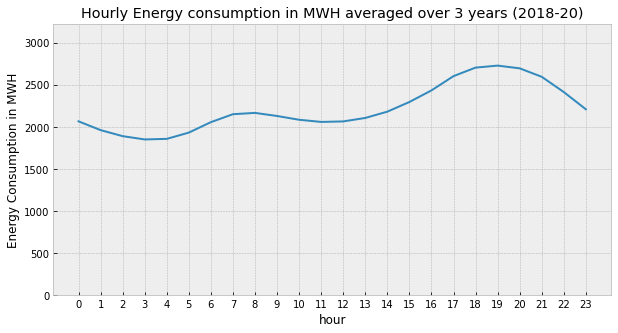

In [78]:
#Plotting average hourly load profile observed over the entire period 
SDGE_t_pv.groupby('hour')['SDGE'].mean().plot(figsize = (10,5))
plt.ylabel('Energy Consumption in MWH')
plt.ylim([0, max(SDGE_t_pv.groupby('hour')['SDGE'].mean()) + 500])
plt.xticks(SDGE_t_pv['hour'].unique())
plt.title('Hourly Energy consumption in MWH averaged over 3 years (2018-20)')



From the above average hourly load profile graph we can observe how the load remains low over the night and then starts increasing as the region wakes up, and continues increasing during the office hours and peaks in the evening when everyone returns home and turns on the electrical appliances in their house.

Plotting average monthly load profile over the entire period 2018-20

Text(0.5, 1.0, 'Monthly Energy consumption in MWH averaged over 5 years (2018-20)')

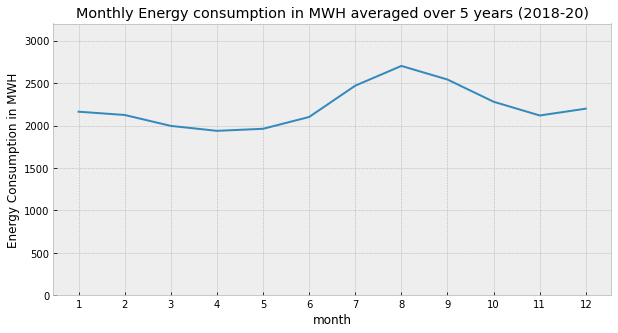

In [79]:
##Plotting average monthly load profile

SDGE_t_pv.groupby('month')['SDGE'].mean().plot(figsize=(10,5))
plt.ylabel('Energy Consumption in MWH')
plt.ylim([0,max(SDGE_t_pv.groupby('month')['SDGE'].mean())+500])
plt.xticks(SDGE_t_pv['month'].unique())
plt.title('Monthly Energy consumption in MWH averaged over 3 years (2018-20)')

As expected the monthly load profile peaks in the summer due to high cooling (air-conditioning) load caused by high temperatures.

Plotting the trend of average monthly energy consumption observed for each month over the past 3 years

In [80]:
#Grouping the dataframe by month and year by applying groupby with an aggregate function of mean; converting the groupby 
#object into a dataframe
df1 = SDGE_t_pv.groupby(['month','year'])['SDGE'].mean()
df1 = pd.DataFrame(df1)
df1

SDGE
month year             
1     2018  2175.356438
      2019  2196.022785
      2020  2119.118187
2     2018  2141.499566
      2019  2184.961679
      2020  2050.311261
3     2018  2061.544109
      2019  2011.787020
      2020  1915.181211
4     2018  2021.883573
      2019  1964.412844
      2020  1827.753732
5     2018  2061.643886
      2019  1973.080291
      2020  1850.991515
6     2018  2179.812324
      2019  2089.138906
      2020  2034.439492
7     2018  2780.217154
      2019  2366.071682
      2020  2264.138399
8     2018  2963.408902
      2019  2512.615226
      2020  2632.002459
9     2018  2458.469569
      2019  2562.557778
      2020  2606.196254
10    2018  2262.524032
      2019  2180.708270
      2020  2398.725484
11    2018  2173.272338
      2019  2105.991239
      2020  2077.192823
12    2018  2226.121990
      2019  2205.356121
      2020  2166.981541

In [81]:
#Unstacking the above dataframe to get the data in a format we can plot
df1un = df1.unstack(level = 'month')
df1un.head()


SDGE                                                      \
month           1            2            3            4            5    
year                                                                     
2018   2175.356438  2141.499566  2061.544109  2021.883573  2061.643886   
2019   2196.022785  2184.961679  2011.787020  1964.412844  1973.080291   
2020   2119.118187  2050.311261  1915.181211  1827.753732  1850.991515   

                                                                        \
month           6            7            8            9            10   
year                                                                     
2018   2179.812324  2780.217154  2963.408902  2458.469569  2262.524032   
2019   2089.138906  2366.071682  2512.615226  2562.557778  2180.708270   
2020   2034.439492  2264.138399  2632.002459  2606.196254  2398.725484   

                                 
month           11           12  
year                             
2018   2173.272338  2226.121990  
2019   2105.991239  2205.356121  
2020   2077.192823  2166.981541

In [82]:
#resetting the index to get year as a column 
df1un.reset_index(inplace = True)

In [83]:
#Melting the above dataframe to get the data in the required format to plot average monthly consumption for each month over the 
#past 5 years 
melt = pd.melt(df1un, id_vars='year', value_name='Avg. monthly energy consumption MWH')
melt.head()


,year,NaN,month,Avg. monthly energy consumption MWH
0,2018,SDGE,1,2175.356438
1,2019,SDGE,1,2196.022785
2,2020,SDGE,1,2119.118187
3,2018,SDGE,2,2141.499566
4,2019,SDGE,2,2184.961679


Text(0.5, 0.98, 'Average monthly energy consumption variation over years 2018 to 2020')

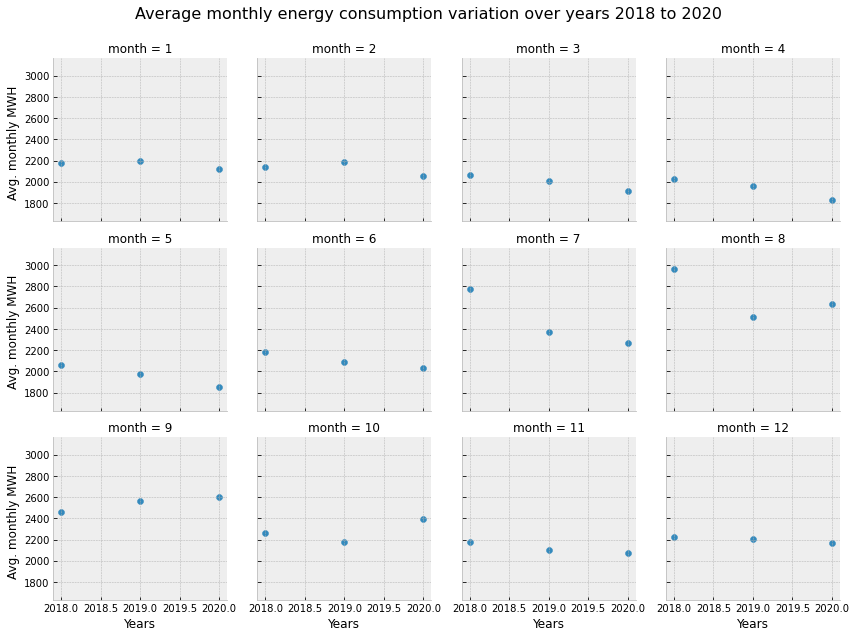

In [84]:
#Plotting each month as a separate graph using Facetgrid

g = sns.FacetGrid(melt,col='month',margin_titles=True,col_wrap=4)
g.map(plt.scatter,'year','Avg. monthly energy consumption MWH')
g.set_axis_labels('Years',"Avg. monthly MWH ");
g.set(ylim=(melt['Avg. monthly energy consumption MWH'].min() - 200, melt['Avg. monthly energy consumption MWH'].max() + 200));
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average monthly energy consumption variation over years 2018 to 2020', fontsize = 16)

A weak trend can be observed in the data, but it is different for different months. For example, April, May, June, September and October months show a considerable downward trend, whereas other months not so much.


Plotting a map of hourly vs weekdays energy consumption to see how the consumption varies across any particular week

In [85]:
#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell will contain the average
#energy consumption for that particular hour of the weekday

hour_weekday = SDGE_t_pv.pivot_table(values='SDGE', index='hour', columns = 'weekday', aggfunc = 'mean')
hour_weekday.head()

weekday,Friday,Monday,Saturdat,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,2078.956110,2017.669794,2099.743012,2055.023610,2073.196574,2067.223460,2066.352899
1,1977.123997,1923.466212,1984.048765,1943.232771,1972.519363,1965.739774,1962.949116
2,1903.305813,1861.664276,1901.961994,1867.639579,1903.381257,1896.848631,1892.822180
3,1865.161389,1832.913476,1852.618891,1819.314043,1867.506090,1861.969519,1855.347993
4,1878.517612,1850.742391,1839.431333,1801.864597,1880.398384,1876.733574,1874.220469


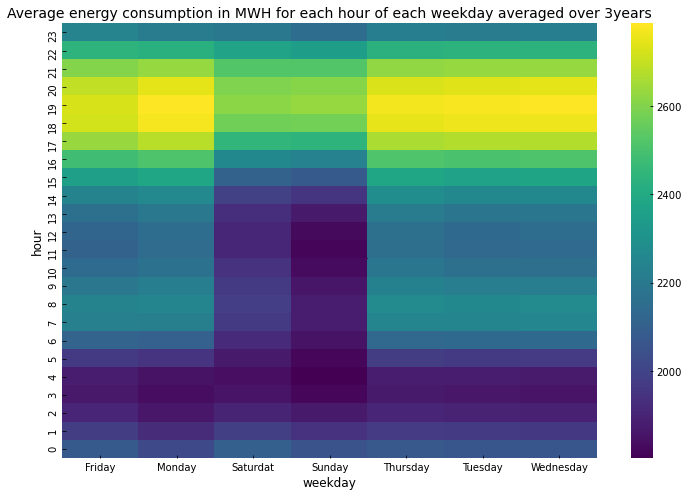

In [86]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
#_ = plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')
_ = ax.set_title("Average energy consumption in MWH for each hour of each weekday averaged over 3years", fontsize = 14)


It can be seen that the average consumption from Monday to Friday is below 2000 in the night and it increases during the day and is at peak (>2800) during the evening time before sliding down again for the night. And on the weekends the same pattern can be observed but the overall consumption seems lower on weekends than weekdays as expected because most of the commercial buildings don't operate on weekends (also maybe because people go out on weekends and are not usually at home?)

Also from all the above graphs it can be seen that the evening consumption is considerably higher than the rest of the day consumption. The reason for this, as pointed out earlier, is that people usually return home from work during evening hours (~4-9pm) and the consumption increases due to the turning on of electronic appliances like lights, TV, computers, air conditioning, etc.

And due to the exact same reason, to keep the load on the electrical grid lower during this time, SDGE (and other utilities) try to discourage people from using more electricity during these hours. SDG&E began transitioning residential customers to Time-of-Use (TOU) pricing plans in early 2019; a TOU plan is one wherein the utility applies different rates to the customers for different time slots during the day. And in fact, SDGE applies highest rate (peak rate) during 4pm to 9pm to its customers as compared to other hours during the day. From SDGE's website: "If customers can shift some of their energy use to lower-cost time periods outside 4 p.m. to 9 p.m., they can lower their electricity bills and make better use of cleaner, renewable energy sources, like wind and solar, when they are more available."

Plotting a histogram to see the overall distribution of the energy consumption for SDGE territory

D:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'count')

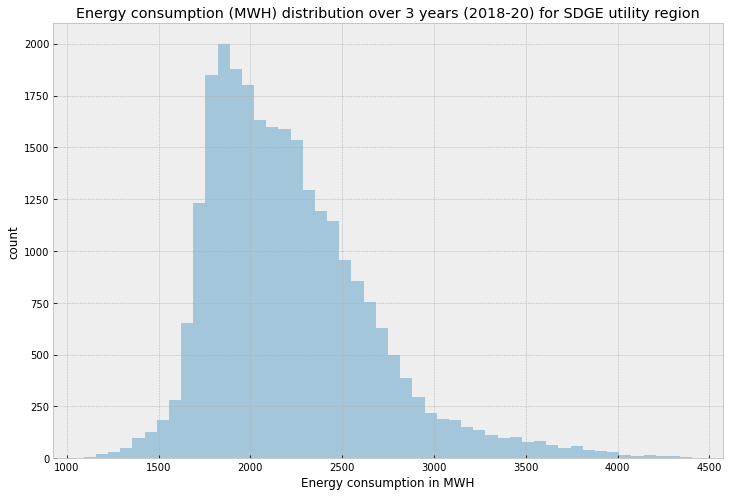

In [87]:

plt.figure(figsize=(12,8))
sns.distplot(SDGE_t_pv['SDGE'], kde=False)
plt.title('Energy consumption (MWH) distribution over 3 years (2018-20) for SDGE utility region')
plt.xlabel('Energy consumption in MWH')
plt.ylabel('count')

It can be seen that most of the days (for 2018-20) have energy consumption between ~1700 to ~2500 MWH and the maximum demand is around ~4500MWH.

Plotting the distribution again but this time using box plot and dividing the columns of the plot by weekdays and adding a hue for working and non-working days

Text(0, 0.5, 'Energy consumption in MWH')

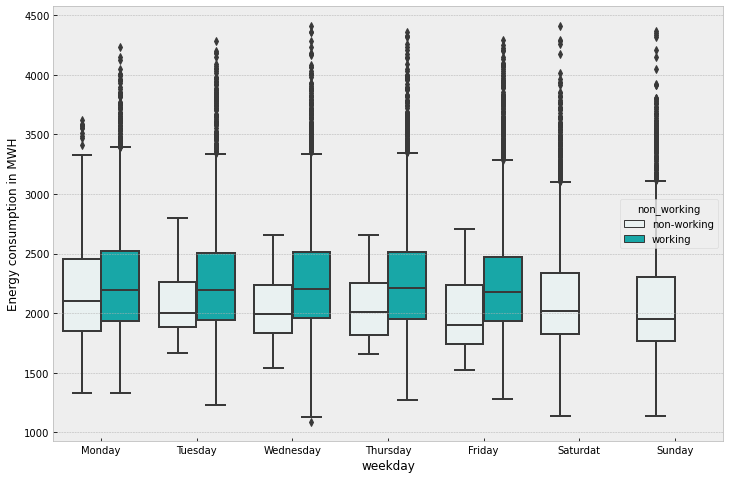

In [88]:

plt.figure(figsize=(12,8))
sns.boxplot(x='weekday',y='SDGE',data=SDGE_t_pv,color='c',hue='non_working')
plt.ylabel('Energy consumption in MWH')

It can be seen that the median energy consumption on working days remains fairly same from Monday to Friday and drops on the weekend as seen before in the heatmap. Also, if a particular day is a holiday or non-working day (indicated in dark green) the energy consumption is much lower than if the same day was a working day as expected.


Visualizing the distribution of energy values for different years

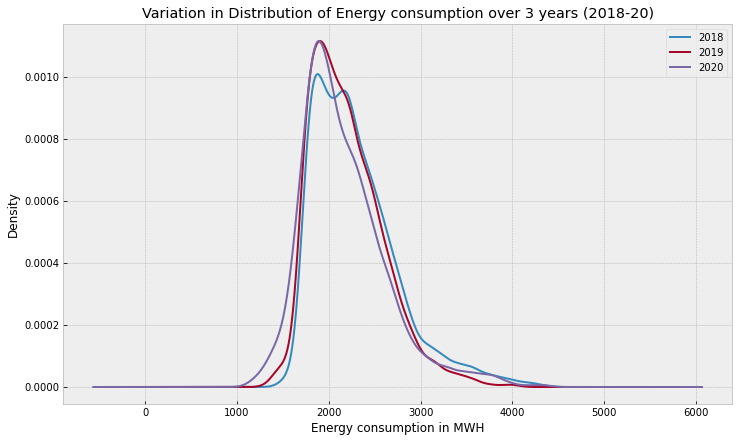

In [89]:

for year in SDGE_t_pv['year'].unique():
    SDGE_t_pv[SDGE_t_pv['year'] == year]['SDGE'].plot(kind='density',figsize=(12,7),legend=True,label=year)
    plt.xlabel('Energy consumption in MWH')
    plt.title('Variation in Distribution of Energy consumption over 3 years (2018-20)')

For all the years the distribution is kind of bi-modal and the mode values for energy consumption consistently shift towards left (towards lower energy load) each year from 2018 to 2020.

This shift can be assumed to be caused by increasing renewable energy installations at customer sites (called as behind the meter) and increasing participation of customers in demand response programs resulting in a lower peak demand on the grid.

Plotting the above distribution for summer and winter seasons separately

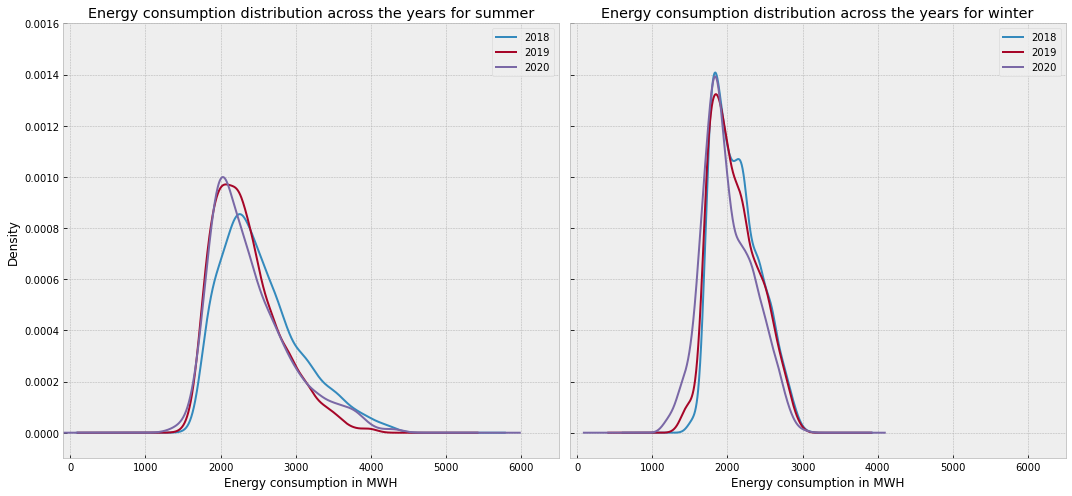

In [90]:

season = ['summer','winter']

for i,season in enumerate(season):
    ax = plt.subplot(121+i)
    for j, year in enumerate(SDGE_t_pv['year'].unique()):
        SDGE_t_pv[(SDGE_t_pv['year']==year) & (SDGE_t_pv['season']==season)]['SDGE'].plot(kind='density',figsize=(15,7),legend=True,
                                                                                         label=year,sharey=True)
        plt.title('Energy consumption distribution across the years for '+season)
        plt.ylim(-0.0001,0.0016)
        plt.xlim(-100,6500)
        plt.xlabel('Energy consumption in MWH')
plt.tight_layout()
    

The energy consumption for summer months is more wide spread and is more right skewed towards higher values as compared to winter months for reasons discussed previously.

Also, the trend of maximum energy consumption shifting towards lower values is more dominant for winter months as compared to the summer months.


Plotting maximum monthly energy consumption (peak demand of a month) over the years 2018-20

Text(0.5, 0, 'Date')

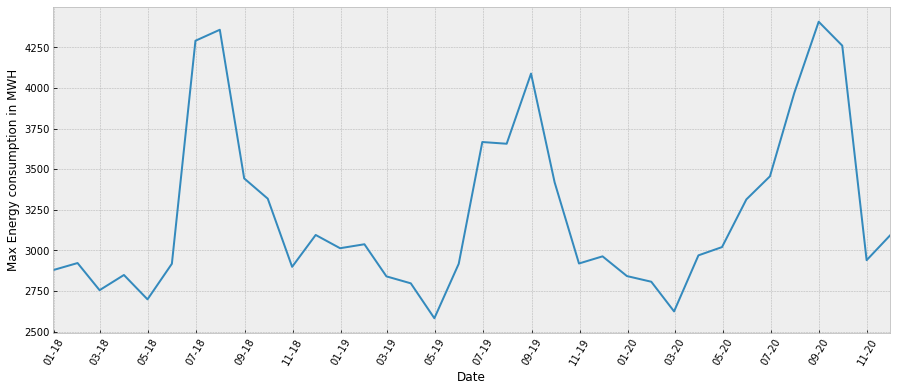

In [91]:
# Resampling the energy data monthly and calculating the max energy consumption for each month
monthly_en = SDGE_t_pv.resample('M', label = 'left')['SDGE'].max()
plt.figure(figsize = (15,6))
#plotting the max monthly energy consumption
plt.plot(monthly_en)
# ensuring the limits on x axis to be between the dataframe's datetime limits
plt.xlim(monthly_en.index.min(), monthly_en.index.max())
# Using matplotlib MonthLocator to be used in the xticks to mark individual months
locator = mdates.MonthLocator(bymonthday = 1, interval = 2)  # every 2 months 
fmt = mdates.DateFormatter('%m-%y')  # xticks to be displayed as 01-14 (i.e. Jan'14) and so on
X = plt.gca().xaxis
# Setting the locator
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation = 60)
plt.ylabel('Max Energy consumption in MWH')
plt.xlabel('Date')
#_ = plt.figure(figsize=(15,6))
#_ = SDGE_t_pv['SDGE'].rolling(24*30).max().plot()


The max monthly peak demand or energy consumption seems to have slightly decreased over the years.

Plotting distribution of energy consumption for every hour over the years

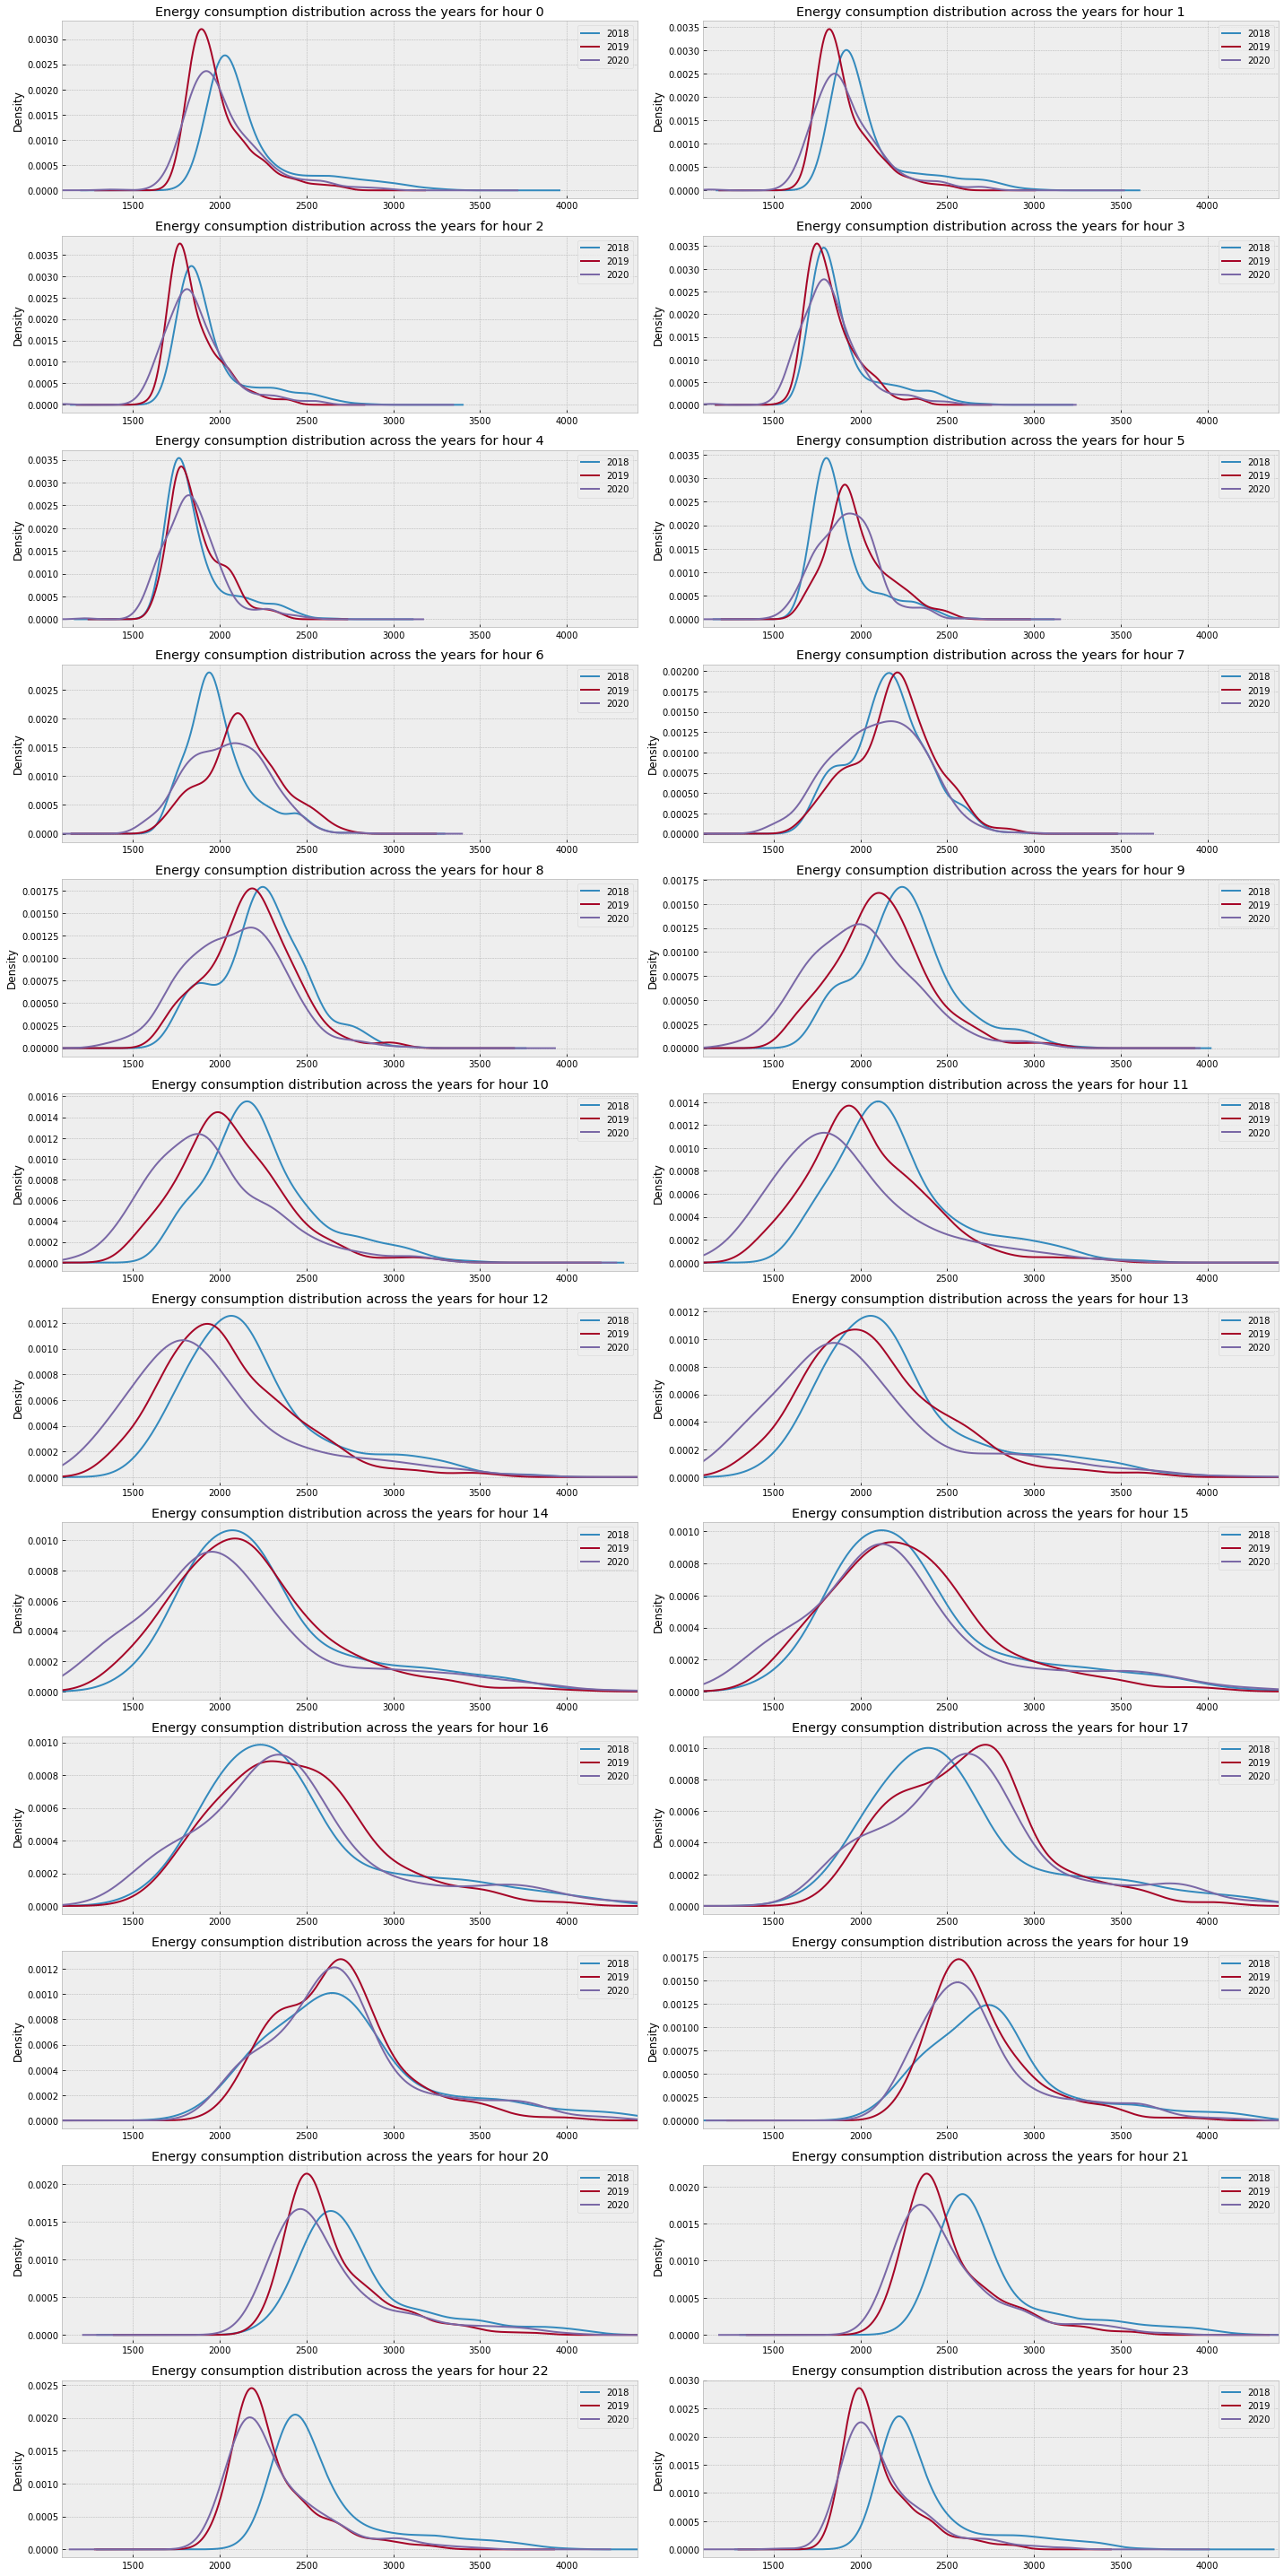

In [92]:
f = plt.figure(figsize = (20,40))
peak_hours = np.arange(0,24) 
for i, hour in enumerate(peak_hours):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(SDGE_t_pv['year'].unique()):
        SDGE_t_pv[(SDGE_t_pv['year'] == year) & (SDGE_t_pv['hour'] == hour)]['SDGE'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)# ,\
                                #c = color_names[j])
    plt.title('Energy consumption distribution across the years for hour '+str(hour))
    plt.xlim(np.min(SDGE_t_pv.SDGE.values), np.max(SDGE_t_pv.SDGE.values))
plt.tight_layout()
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=1)


We can see from the above graphs that the energy consumption distribution for each hour has shifted towards lower energy consumption values from 2018 to 2020, and this effect is more dominant during the daylight hours of 8am to 5pm.

One of the reasons for this shift during daylight hours can be the addition of more renewables like solar and wind behind the customer meters. We will see later that the solar installations in the SDGE have increased considerably over the last 3 years.


2.2 Exploring energy and weather data together

Plotting the energy and weather data together to check for any potential correlation

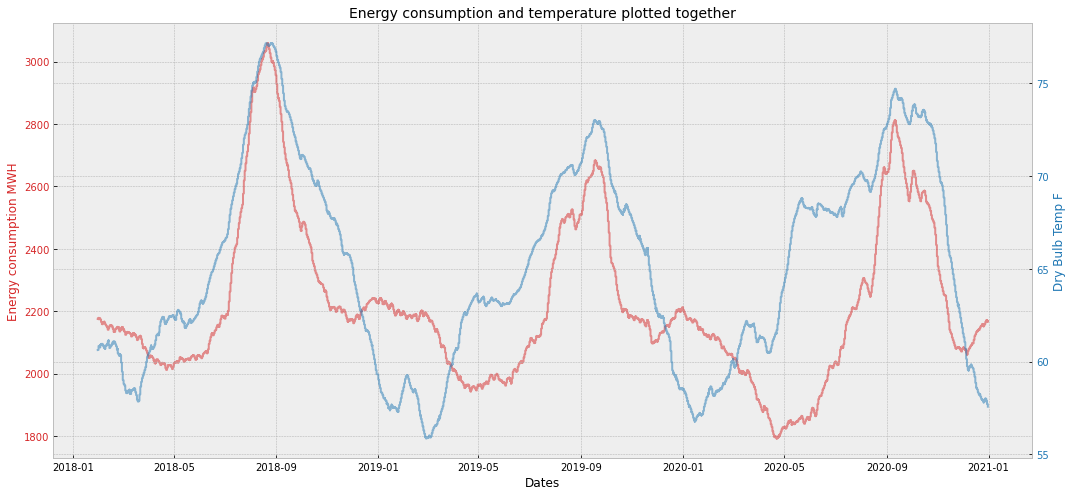

In [94]:
# Plotting the energy and weather data on the same graph as line plots
fig, ax1 = plt.subplots(figsize=(15,7))
rolling_num = 24*30 # smoothing the data a bit by taking the mean of last 'rolling_num' values 
#i.e. plotting the 30 day average energy consumption and temperature values 
color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Energy consumption MWH', color = color)
ax1.plot(SDGE_t_pv['SDGE'].rolling(rolling_num).mean(), color = color, alpha = 0.5)        
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Dry Bulb Temp F', color = color)  # we already handled the x-label with ax1
ax2.plot(SDGE_t_pv['HourlyDryBulbTemperature'].rolling(rolling_num).mean(), color = color, alpha = 0.5)   
ax2.tick_params(axis='y', labelcolor = color)

plt.title('Energy consumption and temperature plotted together', fontsize = 14)
fig.tight_layout()
plt.show()



As suspected before, we can see that the energy consumption and temperature do kind of follow each other and seem to have some level of correlation between them.

More importantly we can see that the highest energy consumption values occur at highest temperatures. This, as mentioned before, is the reason of higher air conditioning loads at higher temperatures.

Plotting a linear regression plot between the energy consumption and temperature

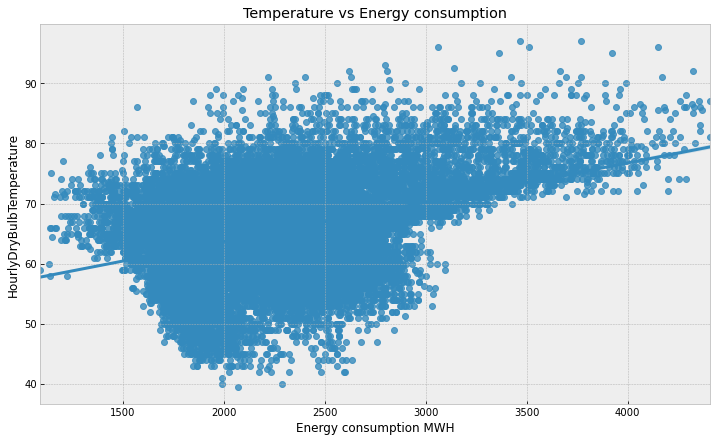

In [96]:
_ = plt.figure(figsize=(12,7))
seasons = ['summer', 'winter' ] # edit this accordingly if you want to plot the regplot for any one particular season
hours = np.arange(0,23) # edit this accordingly if you want to plot the regplot for a particular range of hours
_ = sns.regplot(x= 'SDGE', y= 'HourlyDryBulbTemperature' , data= \
            SDGE_t_pv[(SDGE_t_pv['season'].isin(seasons)) & (SDGE_t_pv['hour'].isin(hours))]) 
_ = plt.xlabel('Energy consumption MWH')
_ = plt.title('Temperature vs Energy consumption')



There seems to be a pretty decent correlation between the energy consumption and the temperature, as suspected before, which is expected because high heat calls out for more air conditioning loads. This correlations gets better if we plot only summer months.

2.3. Exploring energy and PV installations data together

As observed in section 2.1, the energy consumption for daylight hours seems to have decreased from 2018 to 2020. Now, this can be due to stricter energy efficiency measures being mandated, or increase in incentives for different categories of ratepayers (residential, commercial, agriculture, etc.) to install self-generation resources like solar, wind, etc. and/or energy storage in their premises to avoid the higher energy demand. It was observed that the energy consumption decrease over the years is more dominant over the daylight hours, so we can test the theory that maybe solar capacity installed in the utility region has increased over the years, which it has as we will see below.

Plotting the PV installations data over the years

Text(0, 0.5, 'Installed solar (PV) capacity in kW')

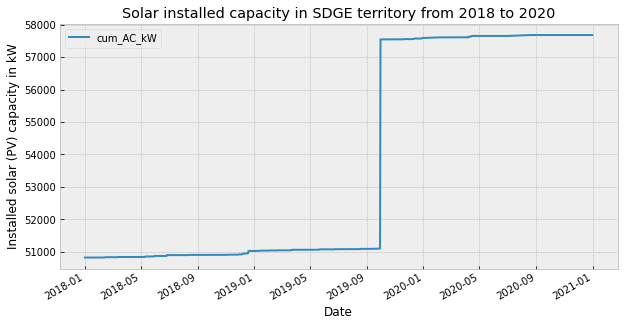

In [97]:

SDGE_t_pv.cum_AC_kW.plot(figsize=(10,5))
plt.legend()
plt.title('Solar installed capacity in SDGE territory from 2018 to 2020')
plt.ylabel('Installed solar (PV) capacity in kW')


It can be seen that there was a considerable increase in the solar installations in the SDGE territory over the past 3 years.

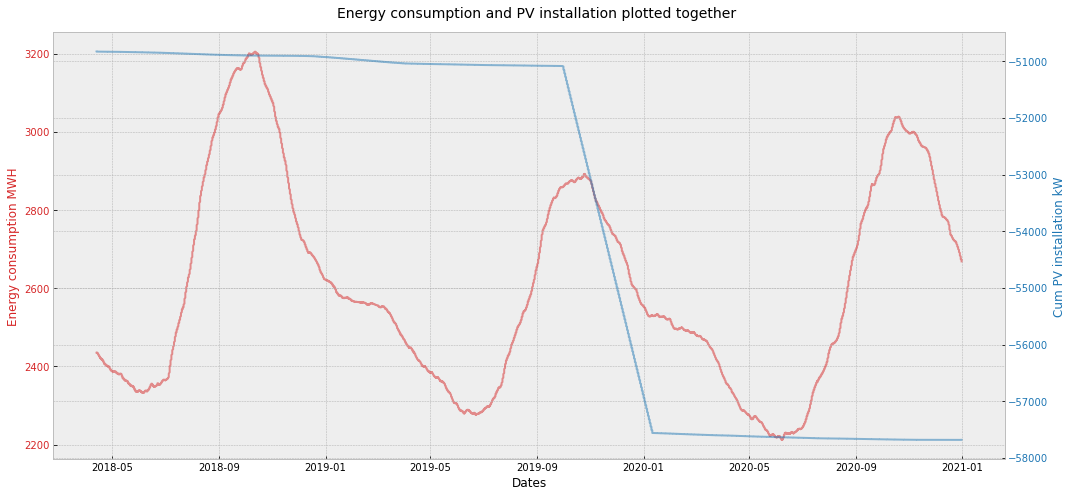

In [109]:
# Plotting the energy and PV data on the same graph as line plots
daylight_hours = np.arange(16,23) # edit this accordingly to select any range of hours
fig, ax1 = plt.subplots(figsize=(15,7))
rolling_num = 24*30 # smoothing the data a bit by taking the mean of last 'rolling_num' values 
 
color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Energy consumption MWH', color = color)
ax1.plot(SDGE_t_pv[SDGE_t_pv.hour.isin(daylight_hours)]['SDGE'].rolling(rolling_num).mean(), 
         color = color, alpha = 0.5)        #.rolling(rolling_num).mean()
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Cum PV installation kW', color = color)  # we already handled the x-label with ax1
ax2.plot(SDGE_t_pv[SDGE_t_pv.hour.isin(daylight_hours)]['cum_AC_kW'].rolling(rolling_num).mean()*(-1), 
         color = color, alpha = 0.5)   #.rolling(rolling_num).mean()
ax2.tick_params(axis='y', labelcolor = color)

fig.suptitle('Energy consumption and PV installation plotted together', fontsize = 14)
fig.tight_layout()
plt.show()



The correlation seems to be significant for both the seasons and is much stronger for winter months. It’s a bit counterintuitive, but colder temperatures are actually better for solar panels than warm temperatures are. This relationship holds true across most types of solar panels – and has nothing to do with the installation process itself. Studies conducted in laboratories all over the world clearly show that increases in temperature have an inverse effect on the total solar output of the panels tested. In other words, the hotter it gets, the less efficient your solar PV system becomes.
Thus, all things being equal, your monthly utility bill savings will be less during June, July, August than they will be in December, February, and January. Ref: https://www.sunlineenergy.com/solar-pv-power-output-san-diegos-winter-months/

In [110]:
#saving the merged dataset as .csv file
SDGE_t_pv.to_csv('hourly1820_energy_temp_PV.csv')